In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")
from pymatreader import read_mat
import IPython
from pathlib import Path
from utilities import perform_fit_rounds, FitInput
from scipy.fft import rfftfreq, rfft, irfft
from scipy.signal import correlate, correlation_lags

In [2]:
NB_NAME = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]).stem

In [3]:
SINEPATH = os.path.join(os.path.abspath(""), "data", NB_NAME, "SineModulation")
SQUAREPATH = os.path.join(os.path.abspath(""), "data", NB_NAME, "SquareModulation")

fnames_sine = sorted(os.listdir(SINEPATH))
fnames_sine = [os.path.join(SINEPATH, fname) for fname in fnames_sine]

fnames_square = sorted(os.listdir(SQUAREPATH))
fnames_square = [os.path.join(SQUAREPATH, fname) for fname in fnames_square]

def get_channels_data(fnames: list[str]):
    t_ch1 = []
    t_ch2 = []
    v_ch1 = []
    v_ch2 = []

    for idx, fname in enumerate(fnames):
        times, voltages = np.loadtxt(fname, delimiter=",", skiprows=1).T
        if (idx % 2) == 0:
            # Time in microseconds
            t_ch1.append(times * 1e6)
            v_ch1.append(voltages)
        else:
            # Time in microseconds
            t_ch2.append(times * 1e6)
            v_ch2.append(voltages)
    
    return t_ch1, v_ch1, t_ch2, v_ch2

# Frequencies in MHz
frequencies_square = np.array([1e-3, 10e-3, 100e-3, 200e-3, 300e-3, 500e-3, 700e-3, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 25, 30, 40])
frequencies_sine = np.array([1e-3, 100e-3, 500e-3, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 25, 30, 40])

times_sine_sync, voltages_sine_sync, times_sine, voltages_sine = get_channels_data(fnames_sine)
times_square_sync, voltages_square_sync, times_square, voltages_square = get_channels_data(fnames_square)

for idx in range(len(frequencies_sine)):
    time_shift = np.min(times_sine_sync[idx])
    times_sine_sync[idx] -= time_shift
    times_sine[idx] -= time_shift

# delete_idc = [9, 10, 11, 12]
# frequencies_sine = np.delete(frequencies_sine, delete_idc)
# times_sine_sync = [elem for idx, elem in enumerate(times_sine_sync) if idx not in delete_idc]
# voltages_sine_sync = [elem for idx, elem in enumerate(voltages_sine_sync) if idx not in delete_idc]
# times_sine = [elem for idx, elem in enumerate(times_sine) if idx not in delete_idc]
# voltages_sine = [elem for idx, elem in enumerate(voltages_sine) if idx not in delete_idc]

Frequency: 0.001MHz


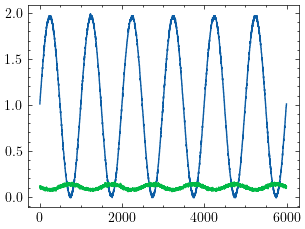

Frequency: 0.1MHz


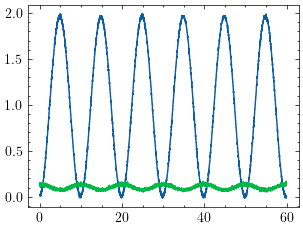

Frequency: 0.5MHz


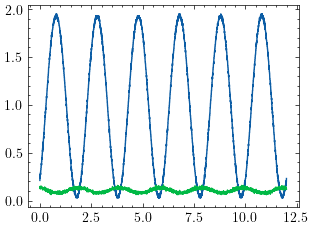

Frequency: 1.0MHz


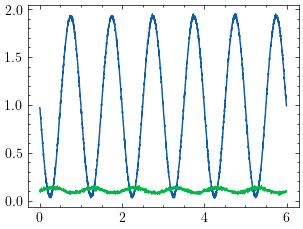

Frequency: 2.0MHz


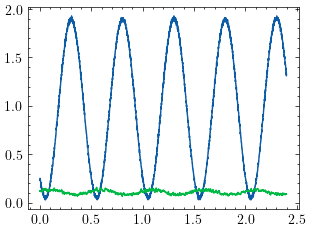

Frequency: 4.0MHz


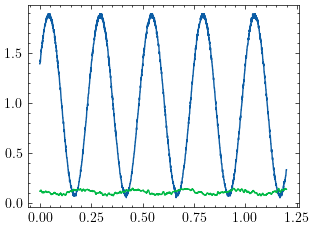

Frequency: 6.0MHz


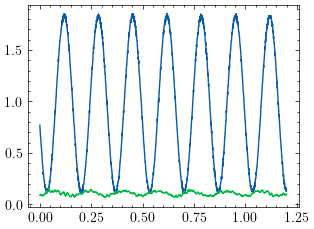

Frequency: 8.0MHz


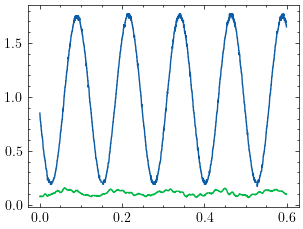

Frequency: 10.0MHz


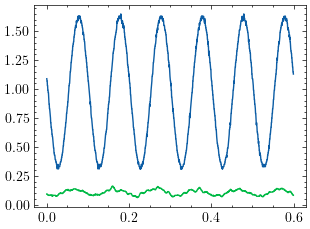

Frequency: 12.0MHz


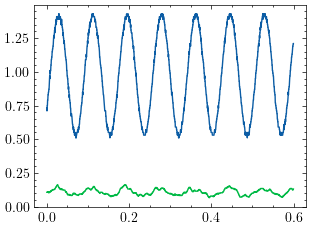

Frequency: 14.0MHz


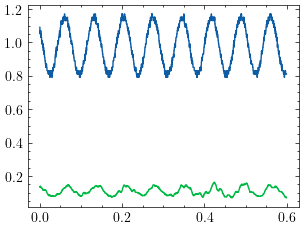

Frequency: 16.0MHz


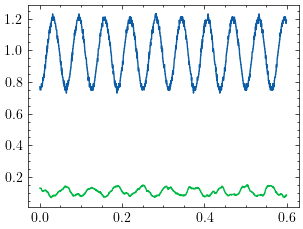

Frequency: 18.0MHz


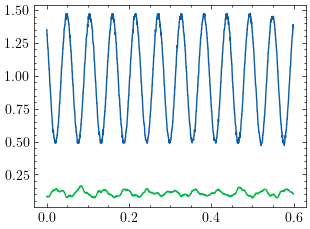

Frequency: 20.0MHz


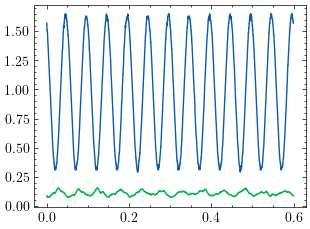

Frequency: 22.0MHz


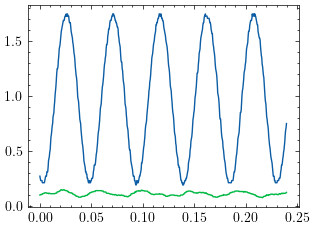

Frequency: 25.0MHz


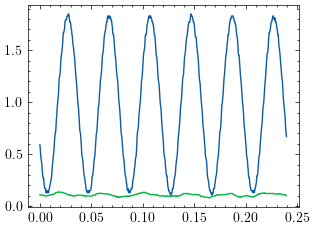

Frequency: 30.0MHz


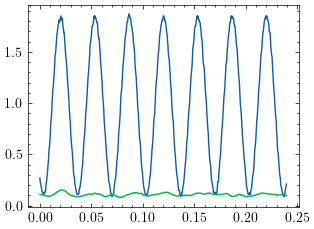

Frequency: 40.0MHz


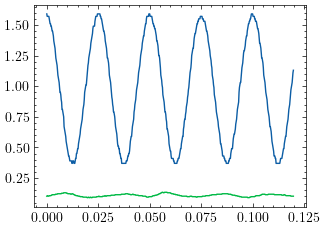

In [4]:
for idx, freq in enumerate(frequencies_sine):
    print(f"Frequency: {freq}MHz")
    plt.plot(times_sine_sync[idx], voltages_sine_sync[idx])
    plt.plot(times_sine[idx], voltages_sine[idx])
    plt.show()

In [5]:
def clean_with_fft(time: np.ndarray, voltage: np.ndarray, cutoff_range: tuple[float, float]):
    N = len(time)
    dt = np.diff(time)[0]

    fft_freqs = rfftfreq(N, dt)
    fft_voltages = rfft(voltage)
    fft_voltages_plotting = rfft(voltage - np.mean(voltage))

    fft_voltages_plotting = np.abs(fft_voltages_plotting[(fft_freqs >= 0) & (fft_freqs <= 45)])
    fft_freqs_plotting = fft_freqs[(fft_freqs >= 0) & (fft_freqs <= 45)]

    cleaned_signal = fft_voltages.copy()
    cleaned_signal[(np.abs(fft_freqs) < cutoff_range[0]) | (np.abs(fft_freqs) > cutoff_range[1])] = 0
    cleaned_signal = irfft(cleaned_signal)

    return fft_freqs_plotting, fft_voltages_plotting, cleaned_signal

Frequecy [MHz] 0.001


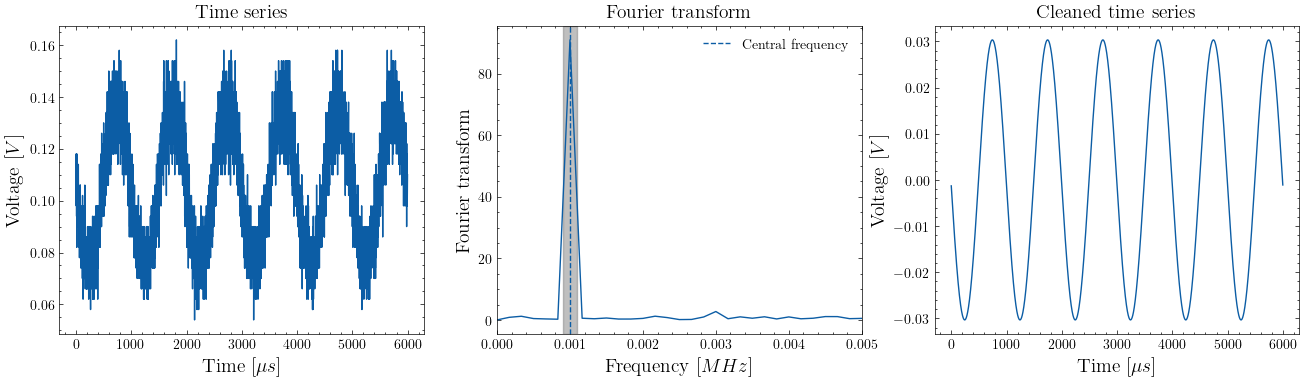

Frequecy [MHz] 0.1


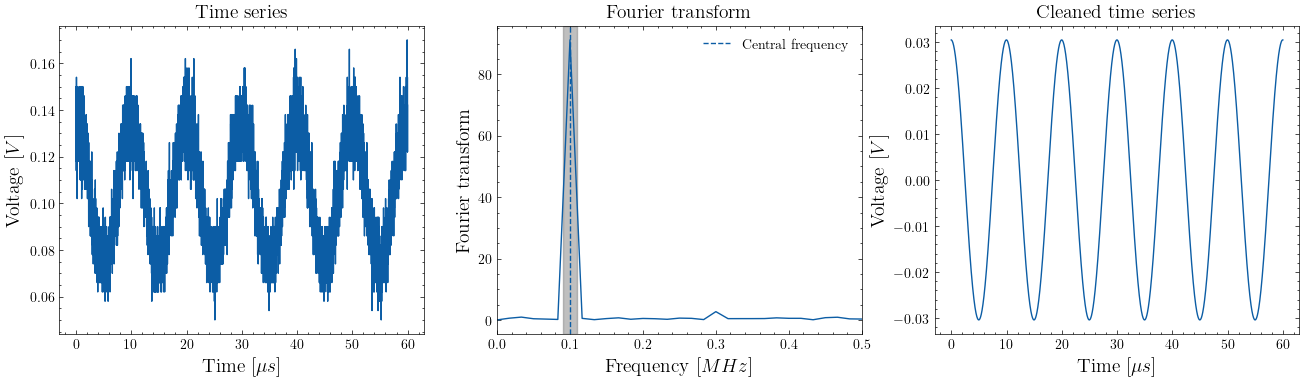

Frequecy [MHz] 0.5


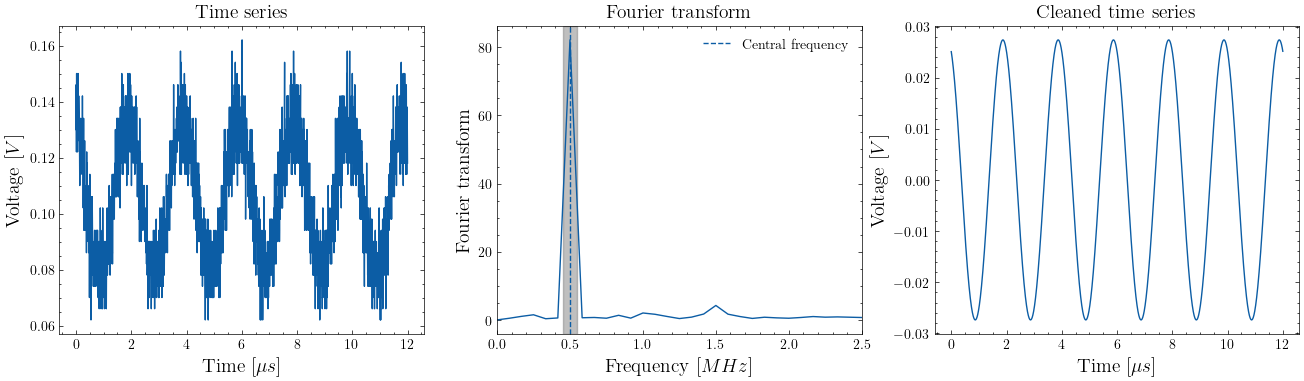

Frequecy [MHz] 1.0


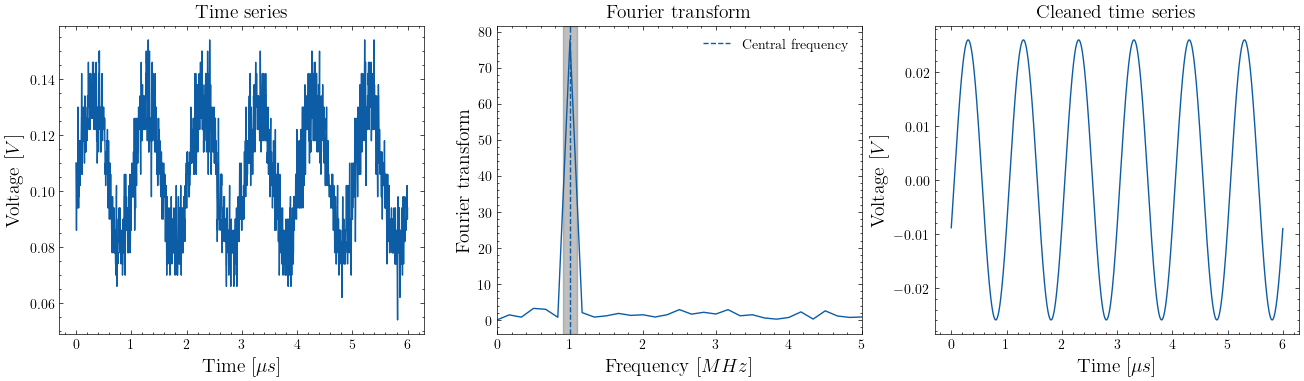

Frequecy [MHz] 2.0


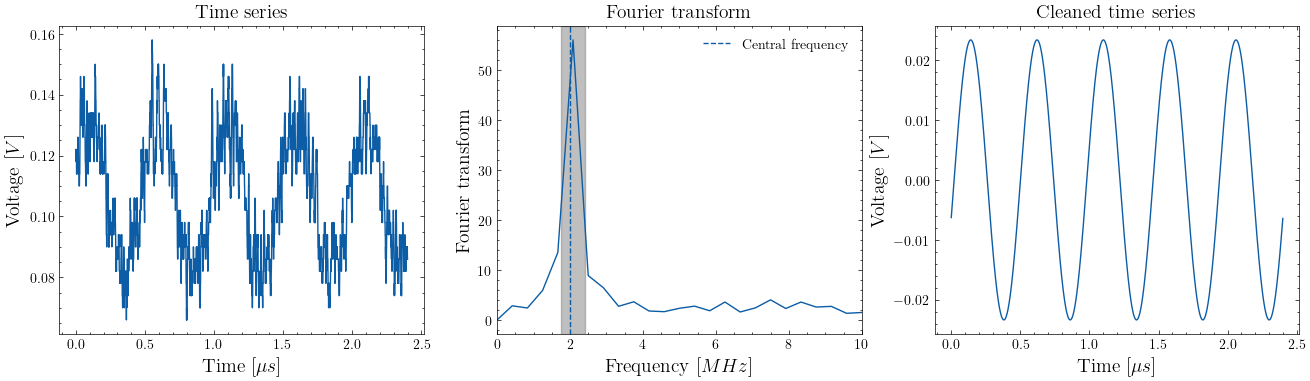

Frequecy [MHz] 4.0


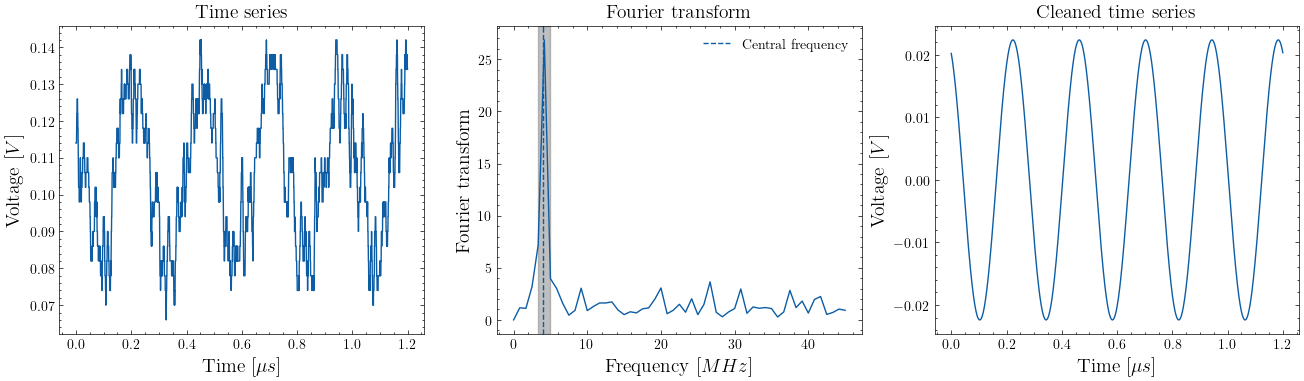

Frequecy [MHz] 6.0


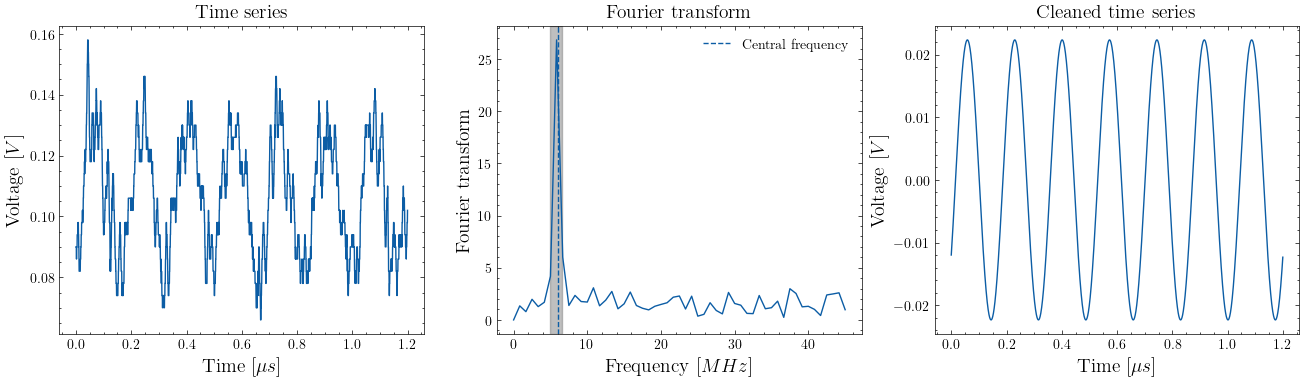

Frequecy [MHz] 8.0


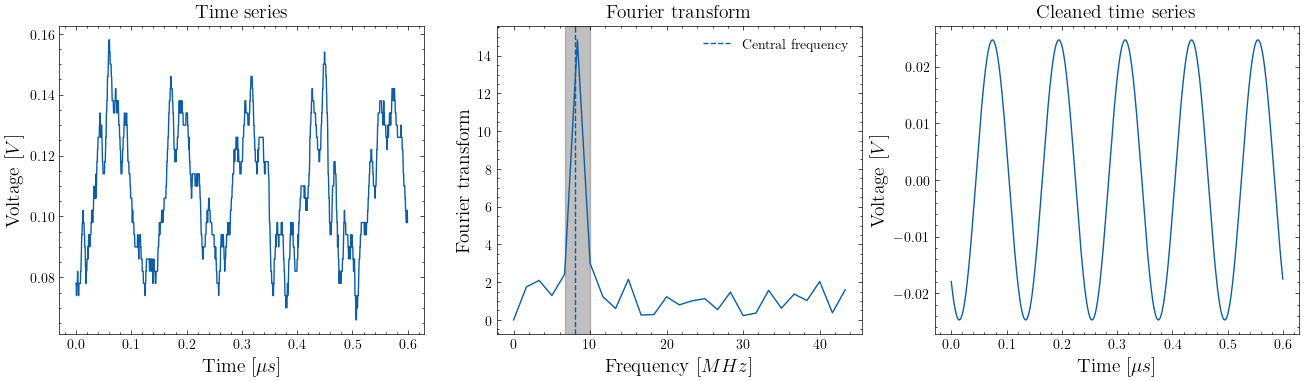

Frequecy [MHz] 10.0


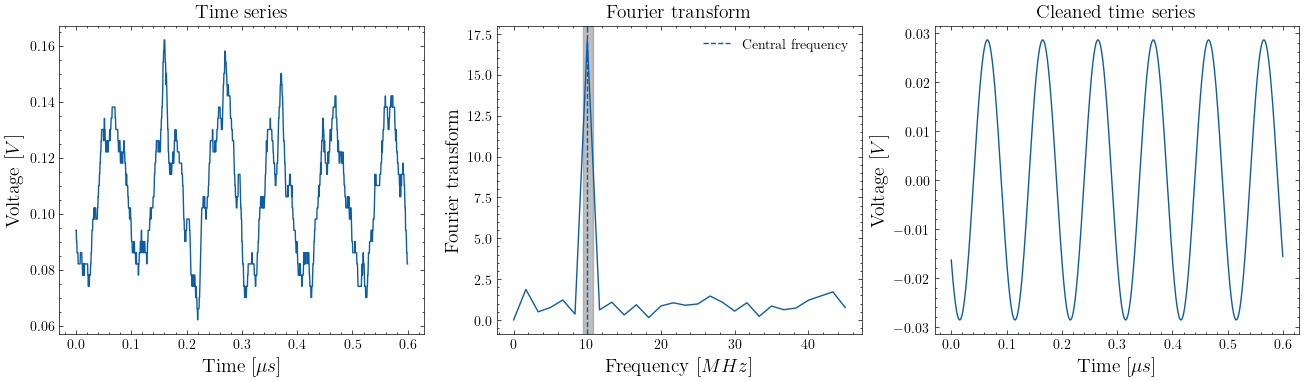

Frequecy [MHz] 12.0


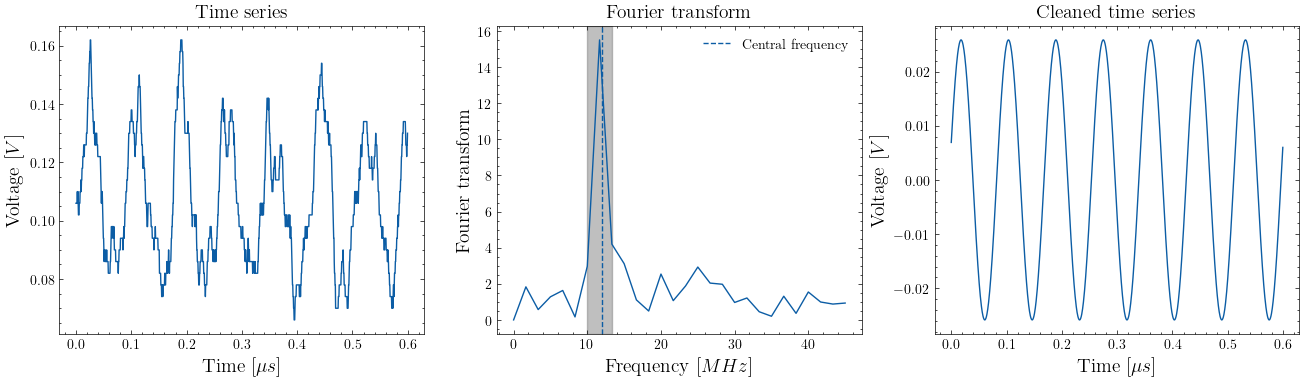

Frequecy [MHz] 14.0


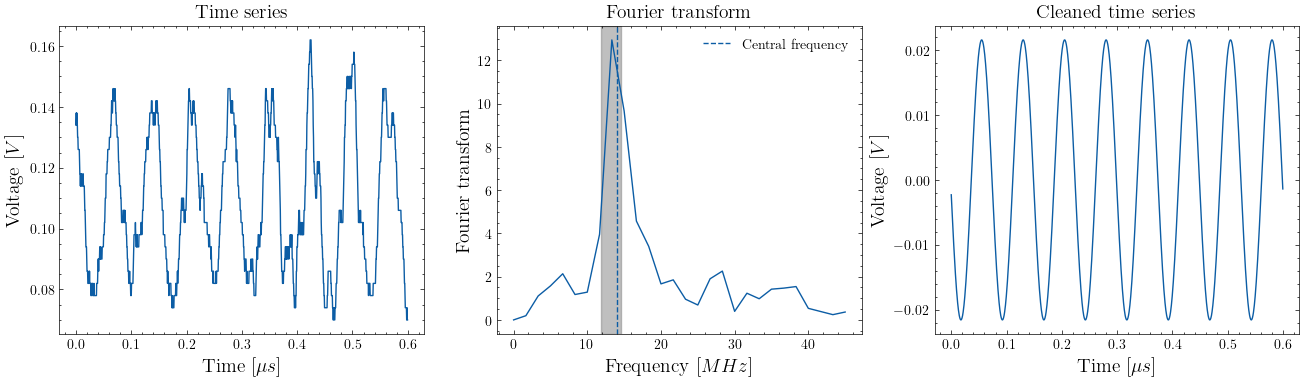

Frequecy [MHz] 16.0


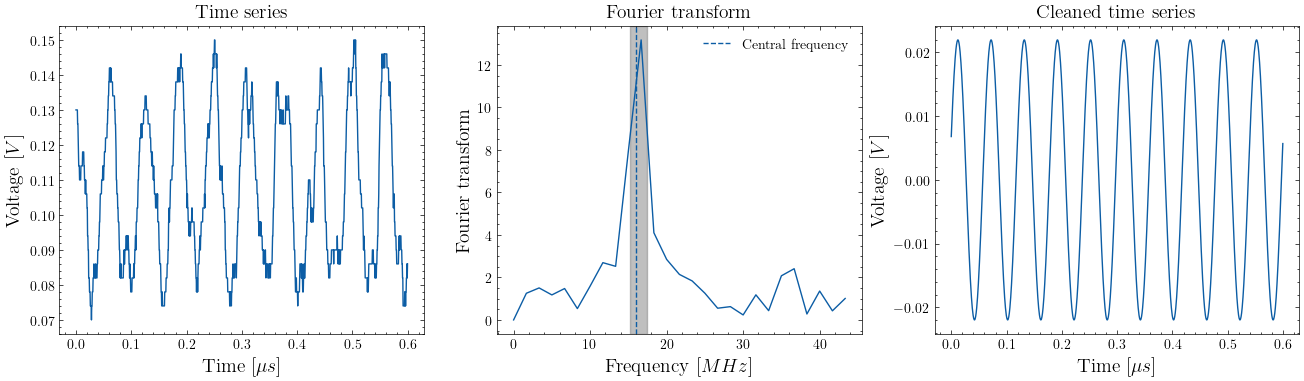

Frequecy [MHz] 18.0


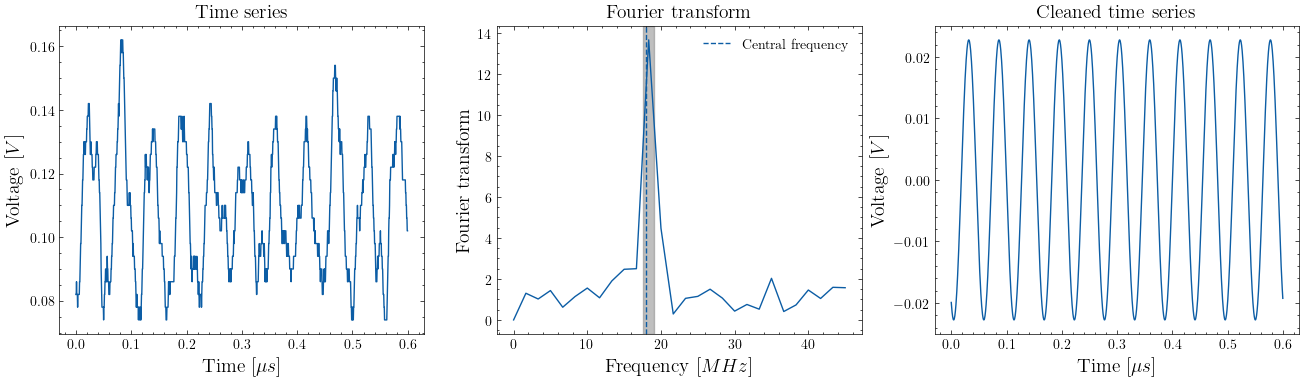

Frequecy [MHz] 20.0


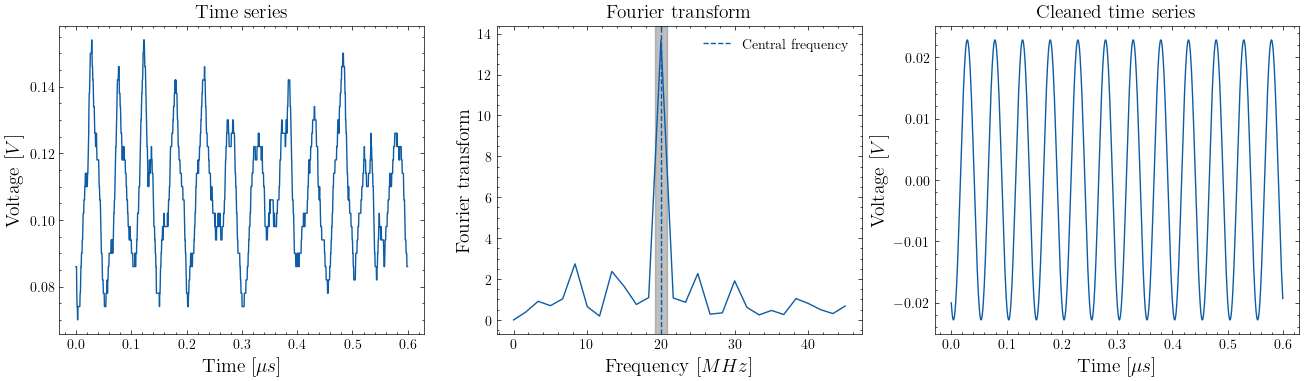

Frequecy [MHz] 22.0


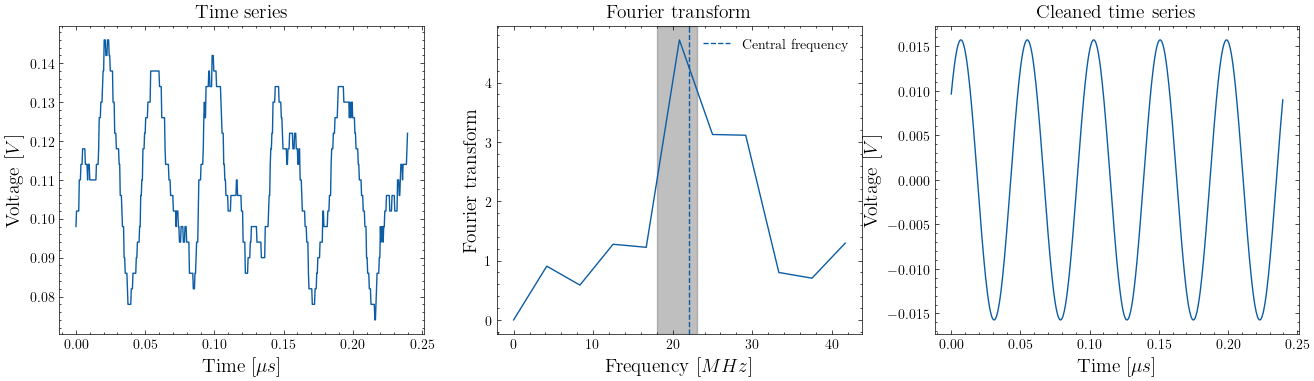

Frequecy [MHz] 25.0


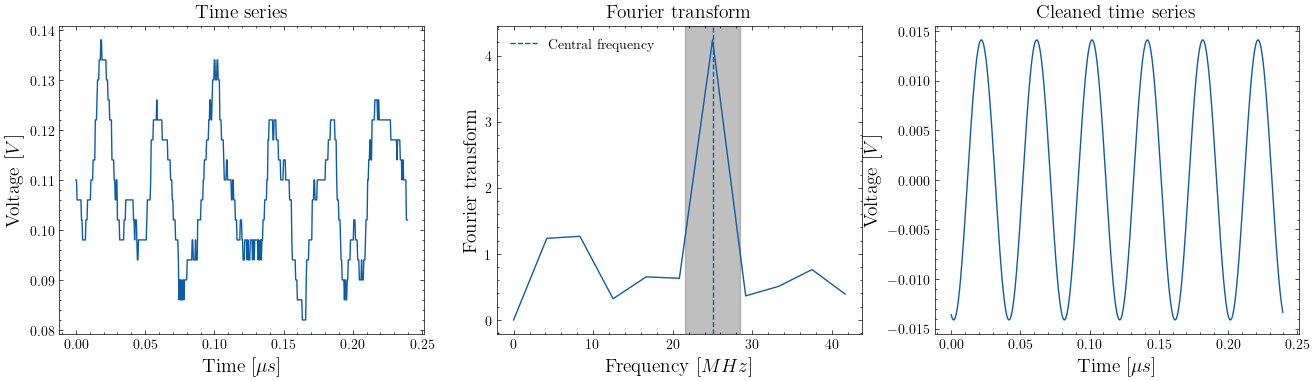

Frequecy [MHz] 30.0


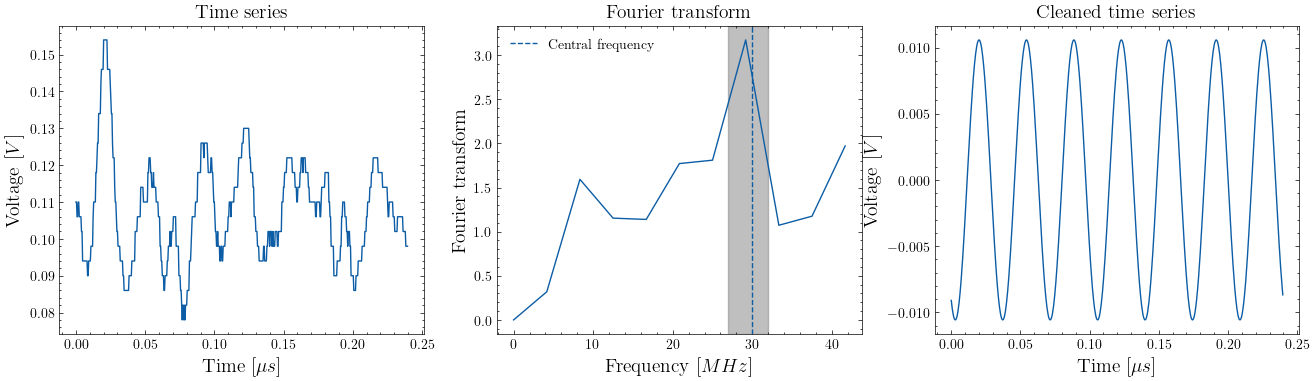

Frequecy [MHz] 40.0


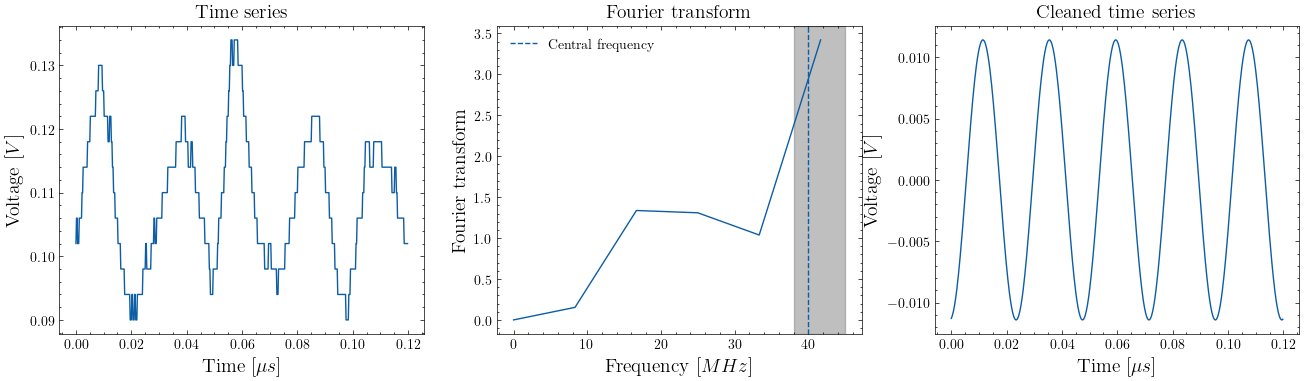

In [6]:
cutoff_ranges =  [
    (0.0009, 0.0011),
    (0.09, 0.11),
    (0.45, 0.55),
    (0.9, 1.1),
    (0.65 + 1.1, 3.5 - 1.1),
    (3.3 + 0.05, 5 - 0.05),
    (5, 6.6),
    (6.6 + 0.1, 10),
    (8.4 + 1, 11.8 - 1),
    (10, 13.4 - 0.1),
    (11.8, 16.6 -2),
    (13.2 + 2, 18.4 - 1),
    (16.6 + 1, 20 - 1),
    (18.2 + 1, 21.8 - 1),
    (18, 23),
    (20.5 + 1, 29.5 - 1),
    (27, 32),
    (38, 45),
]

cleaned_voltages_sine = []

for idx, freq in enumerate(frequencies_sine):
    print(f"Frequecy [MHz] {freq}")
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))

    fft_freqs_plotting, fft_voltages_plotting, cleaned_signal = clean_with_fft(
        times_sine[idx], voltages_sine[idx], cutoff_ranges[idx]
    )

    cleaned_voltages_sine.append(cleaned_signal)

    axs[0].set_title("Time series", fontsize=14)
    axs[0].plot(times_sine[idx], voltages_sine[idx])
    axs[0].set_xlabel("Time [$\mu s$]", fontsize=14)
    axs[0].set_ylabel("Voltage [$V$]", fontsize=14)

    axs[1].set_title("Fourier transform", fontsize=14)
    axs[1].plot(fft_freqs_plotting, fft_voltages_plotting)
    axs[1].set_xlabel("Frequency [$MHz$]", fontsize=14)
    axs[1].set_ylabel("Fourier transform", fontsize=14)
    axs[1].axvline(freq, ls="dashed", label="Central frequency")
    axs[1].axvspan(*cutoff_ranges[idx], color="grey", alpha=0.5)
    if idx < 5:
        axs[1].set_xlim(0, freq * 5)
    axs[1].legend()

    axs[2].set_title("Cleaned time series", fontsize=14)
    axs[2].plot(times_sine[idx], cleaned_signal)
    axs[2].set_xlabel("Time [$\mu s$]", fontsize=14)
    axs[2].set_ylabel("Voltage [$V$]", fontsize=14)

    plt.show()

Frequecy [MHz]0.001
0.9768352599393756 0.04275588698971901 0.9829233332896927


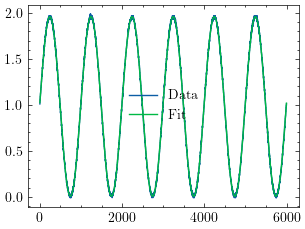

Frequecy [MHz]0.1
0.9808693796124308 4.8011572058616805 0.9835333332885594


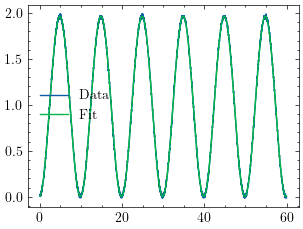

Frequecy [MHz]0.5
0.9456575181964985 5.362126340815216 0.9839999999568735


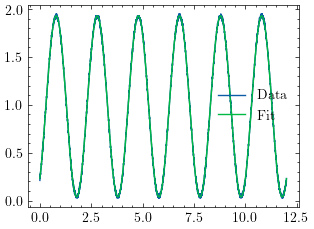

Frequecy [MHz]1.0
0.9386841522449265 3.1498988059118243 0.9837033332867926


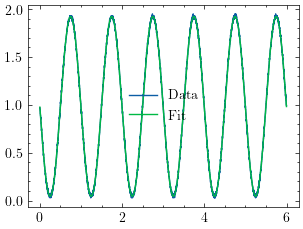

Frequecy [MHz]2.0
0.9230308648770256 4.031767053441176 0.9756328071314944


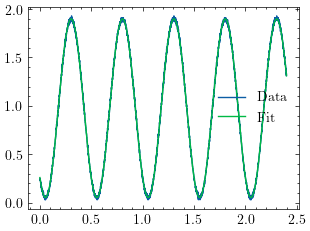

Frequecy [MHz]4.0
0.8990459462262276 0.47039934339627487 0.9764882125805089


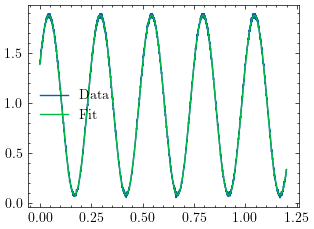

Frequecy [MHz]6.0
0.8534755025498046 3.3959096503437967 0.9758558970398109


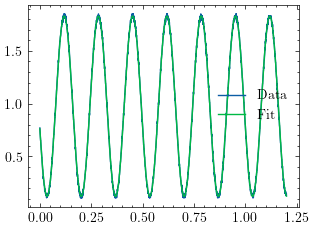

Frequecy [MHz]8.0
0.7769781862967138 3.329208829346423 0.9775459467053486


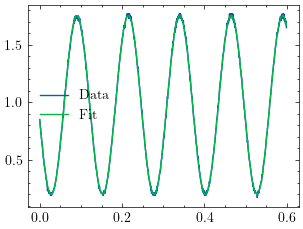

Frequecy [MHz]10.0
0.648168108385784 2.947034934847453 0.9752999999809349


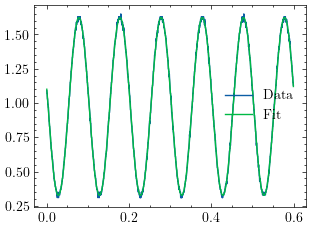

Frequecy [MHz]12.0
0.444583713097344 5.666131218293997 0.9779709665929344


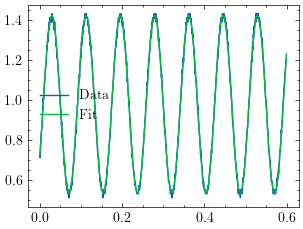

Frequecy [MHz]14.0
0.171449803939012 2.528672672166353 0.9783825148101511


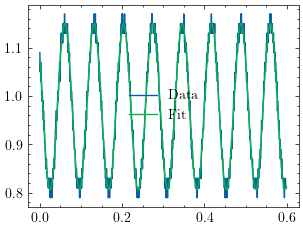

Frequecy [MHz]16.0
0.22189176110420572 4.609407064308069 0.9805722316355089


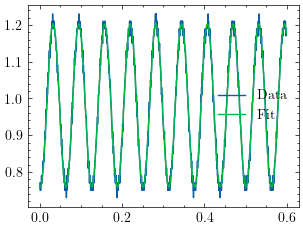

Frequecy [MHz]18.0
0.48260869652563165 2.342696538548526 0.9782729145409514


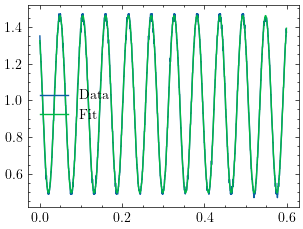

Frequecy [MHz]20.0
0.6606919124851525 2.084776435131146 0.9761833333146122


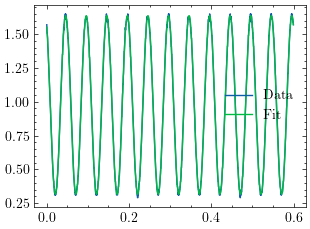

Frequecy [MHz]22.0
0.769268690573418 4.280145202724761 0.9752354815308287


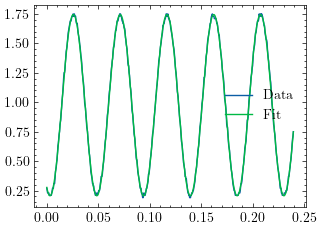

Frequecy [MHz]25.0
0.8501626830838459 3.5912654953051963 0.9760333335123834


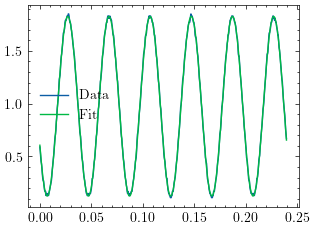

Frequecy [MHz]30.0
0.8702692940513024 4.061964621629562 0.9729129067865138


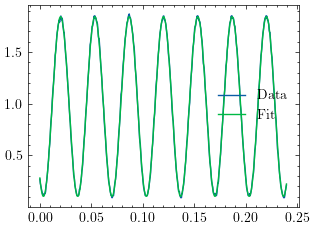

Frequecy [MHz]40.0
0.6049294139169765 1.5627007712089718 0.9767404132762281


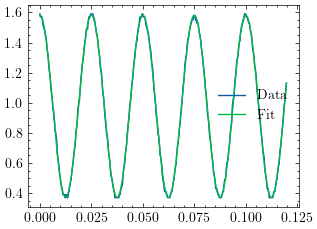

In [7]:
def sine_fit(time, amplitude, phase, shift, frequency):
    return amplitude * np.sin(frequency * 2 * np.pi * time + phase) + shift

fit_results_sine_sync = []

for idx, freq in enumerate(frequencies_sine):
    print(f"Frequecy [MHz]{freq}")
    fit_input = FitInput(
        times_sine_sync[idx],
        voltages_sine_sync[idx],
        0.005,
        lambda time, amplitude, phase, shift: sine_fit(
            time, amplitude, phase, shift, freq
        ),
        [2, 3, 1],
        # sine_fit,
        # [2, 0.1, 1, freq],
    )
    fit_result = perform_fit_rounds(fit_input, bounds={"amplitude": (0, 3), "phase": (0, 10), "shift": (0, 2)}, opt_rounds=20)
    # fit_result = perform_fit_rounds(fit_input, bounds={"amplitude": (0, 5), "phase": (0, None), "shift": (-5, 5), "frequency": (max(0, freq - 1.5 * freq), 1.5 * freq)})
    fit_results_sine_sync.append(fit_result)

    plt.plot(fit_input.xdata, fit_input.ydata, label="Data")
    plt.plot(
        fit_input.xdata,
        fit_input.fit_func(fit_input.xdata, *fit_result.parameters),
        label="Fit",
    )
    print(*fit_result.parameters)
    plt.legend()
    plt.show()

Frequecy [MHz]0.001
0.03032840273870365 3.184071953178425 0.10573533333803137


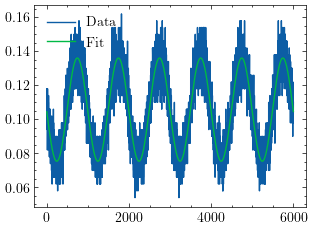

Frequecy [MHz]0.1
0.030415271483031792 7.86870540811281 0.10496333333759364


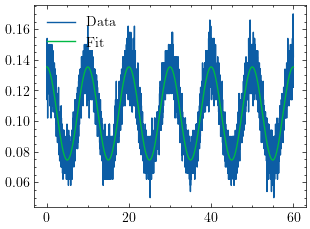

Frequecy [MHz]0.5
0.02738409141882578 1.9830878501044014 0.10631933333870704


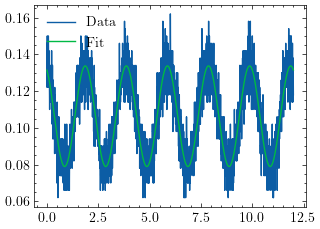

Frequecy [MHz]1.0
0.025907472550163565 5.9343745914901715 0.1068386666725666


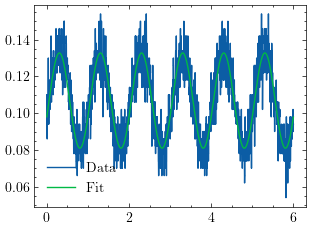

Frequecy [MHz]2.0
0.02450365542789023 6.615154212302946 0.10692736688235523


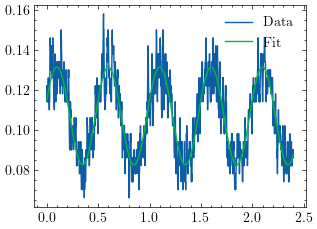

Frequecy [MHz]4.0
0.0239430100215576 2.6305548829782883 0.10670348759756325


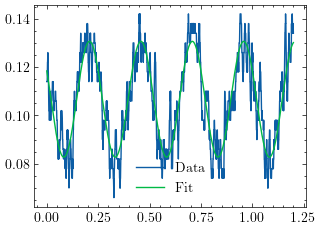

Frequecy [MHz]6.0
0.023458743597485468 5.108451781131345 0.10733832477290786


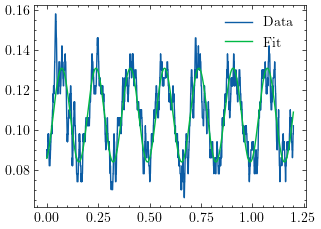

Frequecy [MHz]8.0
0.026127952142522667 4.590813921435803 0.10832360388260459


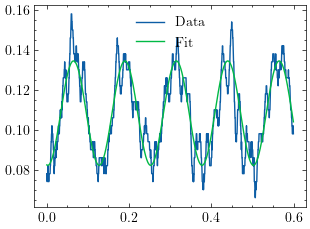

Frequecy [MHz]10.0
0.028560512411394227 3.7514323012280557 0.10761000000500545


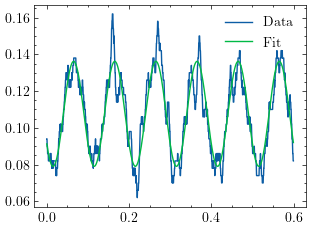

Frequecy [MHz]12.0
0.028338818012167668 5.92325981423304 0.1071647980131302


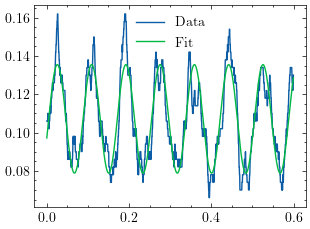

Frequecy [MHz]14.0
0.030260277092984858 1.9379578652043414 0.1086571490280348


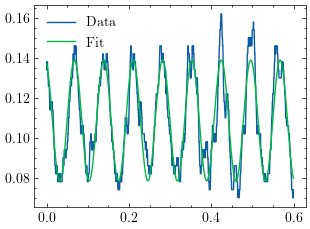

Frequecy [MHz]16.0
0.02803177000485828 7.9045438857484225 0.10750777835492453


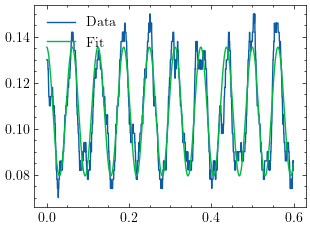

Frequecy [MHz]18.0
0.024788751437801747 4.822426164536351 0.10837973982688735


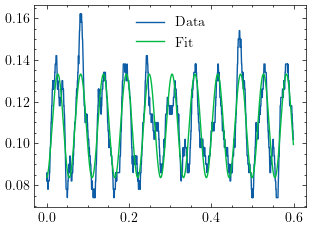

Frequecy [MHz]20.0
0.022823105947525246 4.214006441466869 0.10796666666524453


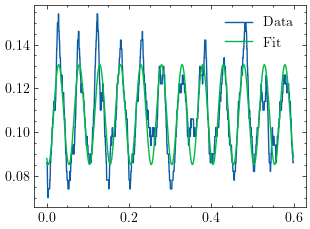

Frequecy [MHz]22.0
0.0198068661041116 5.970319388752717 0.10930759478421333


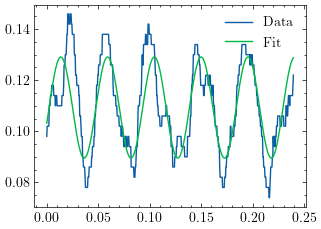

Frequecy [MHz]25.0
0.014122807292919964 4.441122077942669 0.10780666667094015


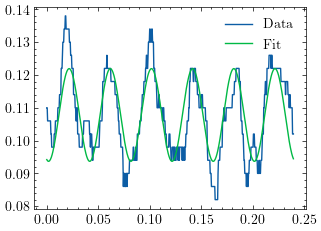

Frequecy [MHz]30.0
0.011560475372198578 3.7476172569226436 0.10799965756225541


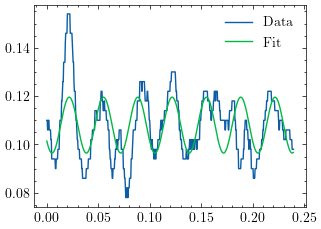

Frequecy [MHz]40.0
0.012806518980115552 5.463135157110177 0.10877646040951261


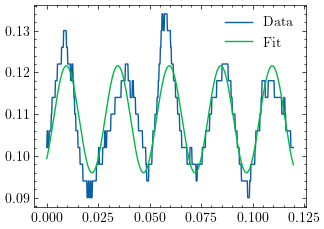

In [8]:
fit_results_sine_nonclean = []

for idx, freq in enumerate(frequencies_sine):
    print(f"Frequecy [MHz]{freq}")
    fit_input = FitInput(
        times_sine[idx],
        voltages_sine[idx],
        0.01,
        lambda time, amplitude, phase, shift: sine_fit(
            time, amplitude, phase, shift, freq
        ),
        [0.01, 5, 0.1],
    )

    fit_result = perform_fit_rounds(fit_input, bounds={"amplitude": (0.005, 0.3), "phase": (0, 20), "shift": (0, 0.2)})
    fit_results_sine_nonclean.append(fit_result)

    plt.plot(fit_input.xdata, fit_input.ydata, label="Data")
    plt.plot(
        fit_input.xdata,
        fit_input.fit_func(fit_input.xdata, *fit_result.parameters),
        label="Fit",
    )
    print(*fit_result.parameters)
    plt.legend()
    plt.show()

Frequecy [MHz]0.001
0.030328412410864335 3.1840762437211434 -1.3251527843788358e-09 0.0009999997986765128


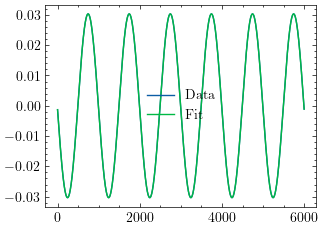

Frequecy [MHz]0.1
0.030415271813968355 7.868705375643546 8.742763544372645e-11 0.10000000014994345


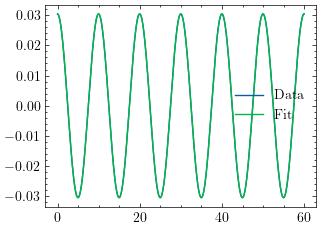

Frequecy [MHz]0.5
0.02738417311708606 1.9830906183888264 -4.793431523410219e-08 0.5000001195467751


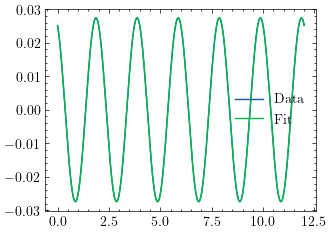

Frequecy [MHz]1.0
0.0259076222305038 5.934316820582253 -1.3977525010599318e-07 1.0000025291899104


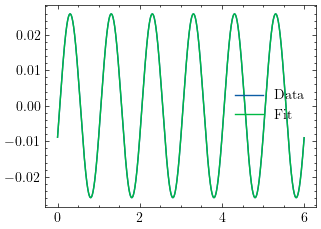

Frequecy [MHz]2.0
0.023355506348844503 6.010850834026465 1.0934605873449271e-07 2.0833345284144396


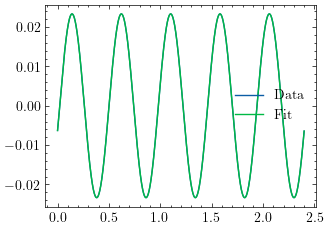

Frequecy [MHz]4.0
0.02238505350522048 2.0140747869821287 2.8133002749879815e-08 4.166669746379913


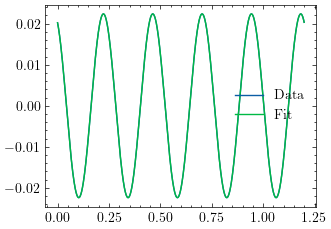

Frequecy [MHz]6.0
0.02235851385669112 5.7168726505182805 -1.2650817836877548e-09 5.833333760416161


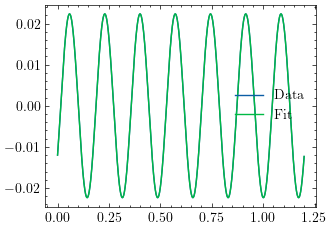

Frequecy [MHz]8.0
0.02472108290515796 3.9537889699759994 -1.2532276028563716e-09 8.333332842057548


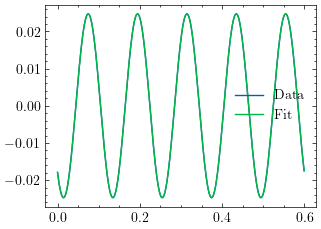

Frequecy [MHz]10.0
0.028560619996335045 3.7514529739857667 -1.150515900926255e-07 9.999989059376677


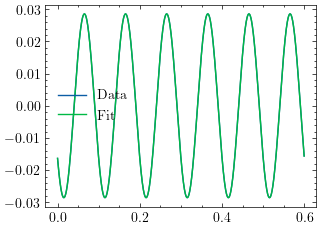

Frequecy [MHz]12.0
0.025846906391083557 6.554225127950037 3.418422705884008e-08 11.666673336527008


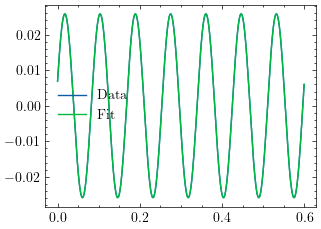

Frequecy [MHz]14.0
0.021569947102249545 3.2480047262246754 -5.2318373820747777e-08 13.333329275969511


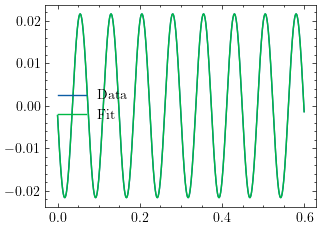

Frequecy [MHz]16.0
0.02196973002756426 6.59814554258708 7.248356340052581e-09 16.666652934308946


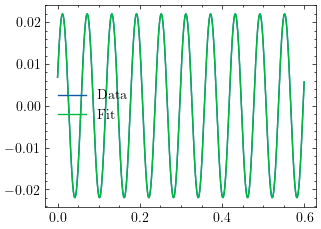

Frequecy [MHz]18.0
0.022760463402332315 4.207558058628389 3.0140121631133665e-09 18.333337857750173


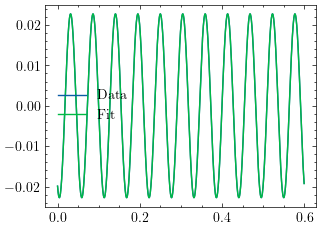

Frequecy [MHz]20.0
0.02282307028189292 4.213989851080791 1.5742973205438993e-08 20.000006371477067


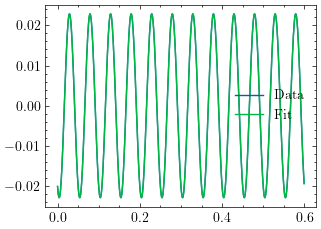

Frequecy [MHz]22.0
0.015728660949315836 6.944231760599923 -5.122762939454434e-08 20.83333753739131


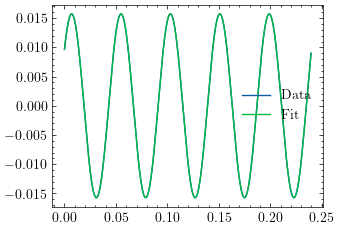

Frequecy [MHz]25.0
0.014122802867394188 4.441150098210961 7.291427604402823e-08 24.999960410687397


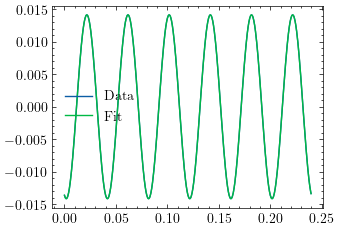

Frequecy [MHz]30.0
0.010573092585039134 4.178134405979268 6.149612707560467e-08 29.166476972343276


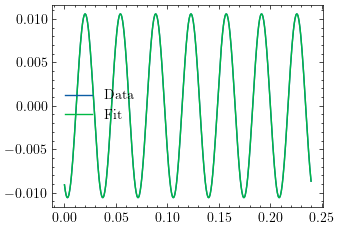

Frequecy [MHz]40.0
0.0114042993813375 4.861112521310474 1.997609915113316e-07 41.66665995106324


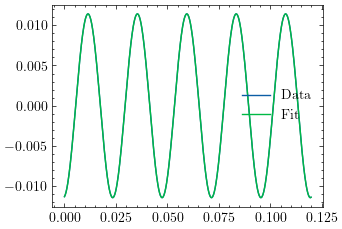

In [9]:
fit_results_sine = []

for idx, freq in enumerate(frequencies_sine):
    print(f"Frequecy [MHz]{freq}")
    fit_input = FitInput(
        times_sine[idx],
        cleaned_voltages_sine[idx],
        # voltages_sine[idx],
        0.01,
        # lambda time, amplitude, phase, shift: sine_fit(
        #     time, amplitude, phase, shift, freq
        # ),
        # [0.01, 5, 0.1],
        sine_fit,
        [0.01, 5, 0, freq],
    )
    freq_range = (max(0, freq - 2), freq + 2)
    fit_result = perform_fit_rounds(fit_input, bounds={"amplitude": (0, 5), "phase": (0, 30), "shift": (-5, 5), "frequency": freq_range})
    # fit_result = perform_fit_rounds(fit_input, bounds={"amplitude": (0.005, 0.3), "phase": (0, 20), "shift": (0, 0.2)})
    fit_results_sine.append(fit_result)

    plt.plot(fit_input.xdata, fit_input.ydata, label="Data")
    plt.plot(
        fit_input.xdata,
        fit_input.fit_func(fit_input.xdata, *fit_result.parameters),
        label="Fit",
    )
    print(*fit_result.parameters)
    plt.legend()
    plt.show()

In [21]:
# phase_diffs_sine = list(map(lambda x: x[1].parameters[1] - x[0].parameters[1], zip(fit_results_sine_sync, fit_results_sine)))
phase_diffs_sine = list(map(lambda x: x[1].parameters[1] % (2 * np.pi) - x[0].parameters[1] % (2 * np.pi), zip(fit_results_sine_sync, fit_results_sine)))
phase_diffs_sine1_clean = []
phase_diffs_sine1_nonclean = []
phase_diffs_sine1_data = []

phase_diffs_sine2_clean = []
for idx, freq in enumerate(frequencies_sine):
    result_clean = fit_results_sine[idx]
    result_nonclean = fit_results_sine_nonclean[idx]
    result_sync = fit_results_sine_sync[idx]
    y_fit_clean = sine_fit(times_sine[idx], *result_clean.parameters)
    y_fit_nonclean = sine_fit(times_sine[idx], *result_nonclean.parameters, freq)
    y_fit_sync = sine_fit(times_sine_sync[idx], *result_sync.parameters, freq)

    phase_diffs_sine1_data.append(np.arccos(np.dot(voltages_sine[idx], voltages_sine_sync[idx]) / (np.linalg.norm(voltages_sine_sync[idx]) * np.linalg.norm(voltages_sine[idx]))))
    phase_diffs_sine1_clean.append(np.arccos(np.dot(y_fit_clean, y_fit_sync) / (np.linalg.norm(y_fit_sync) * np.linalg.norm(y_fit_clean))))
    phase_diffs_sine1_nonclean.append(np.arccos(np.dot(y_fit_nonclean, y_fit_sync) / (np.linalg.norm(y_fit_sync) * np.linalg.norm(y_fit_nonclean))))
    phase_diffs_sine2_clean.append(np.arccos((np.mean(y_fit_clean * y_fit_sync) - result_sync.parameters[2] * result_clean.parameters[2]) * 2 / (result_sync.parameters[0] * result_clean.parameters[0])))

amplitudes_sine = [res.parameters[0] for res in fit_results_sine]

/tmp/ipykernel_735483/402554375.py:19: RuntimeWarning: invalid value encountered in arccos
  phase_diffs_sine2_clean.append(np.arccos((np.mean(y_fit_clean * y_fit_sync) - result_sync.parameters[2] * result_clean.parameters[2]) * 2 / (result_sync.parameters[0] * result_clean.parameters[0])))


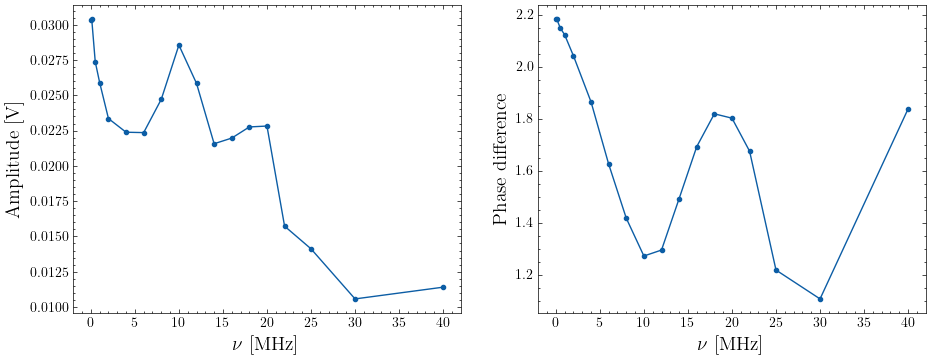

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.plot(frequencies_sine, amplitudes_sine, '.-')
ax1.set_xlabel(r"$\nu$ [MHz]", fontsize=14)
ax1.set_ylabel(r"Amplitude [V]", fontsize=14)
ax2.plot(frequencies_sine, phase_diffs_sine1_clean, '.-')
ax2.set_xlabel(r"$\nu$ [MHz]", fontsize=14)
ax2.set_ylabel(r"Phase difference", fontsize=14)
plt.show()


Text(0, 0.5, 'Phase difference')

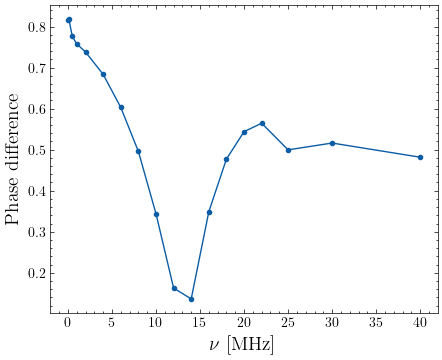

In [12]:
plt.figure(figsize=(5, 4))
plt.plot(frequencies_sine, phase_diffs_sine1_data, '.-')
plt.xlabel(r"$\nu$ [MHz]", fontsize=14)
plt.ylabel(r"Phase difference", fontsize=14)


Text(0, 0.5, 'Phase difference')

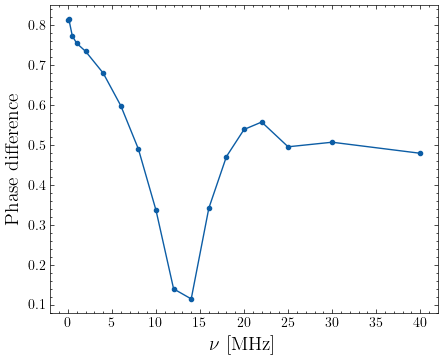

In [13]:
plt.figure(figsize=(5, 4))
plt.plot(frequencies_sine, phase_diffs_sine1_nonclean, '.-')
plt.xlabel(r"$\nu$ [MHz]", fontsize=14)
plt.ylabel(r"Phase difference", fontsize=14)


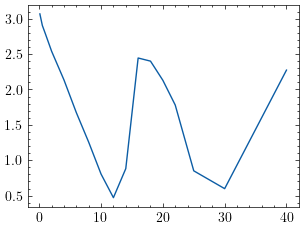

In [25]:
plt.plot(frequencies_sine, phase_diffs_sine2_clean)